<a href="https://colab.research.google.com/github/hoangndst/ml-notebooks/blob/master/mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets # MNIST datasets
from torchvision.transforms import ToTensor# transform PIL image to torch.Tensor
from torch import nn # neural network library
import torch
import matplotlib.pyplot as plt # print image
from torch.utils.data import DataLoader # mini-batch loader

In [ ]:
# training set
train_ds = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
# test set
test_ds = datasets.MNIST('./data', train=False, download=True, transform=ToTensor())

print(f"train {len(train_ds)} test {len(test_ds)}")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train 60000 test 10000


In [ ]:
# the first training sample
x, y = train_ds[0]
print("input type", type(x))
print("input size", x.shape)
print("output type", type(y))
print("target", y)

input type <class 'torch.Tensor'>
input size torch.Size([1, 28, 28])
output type <class 'int'>
target 5


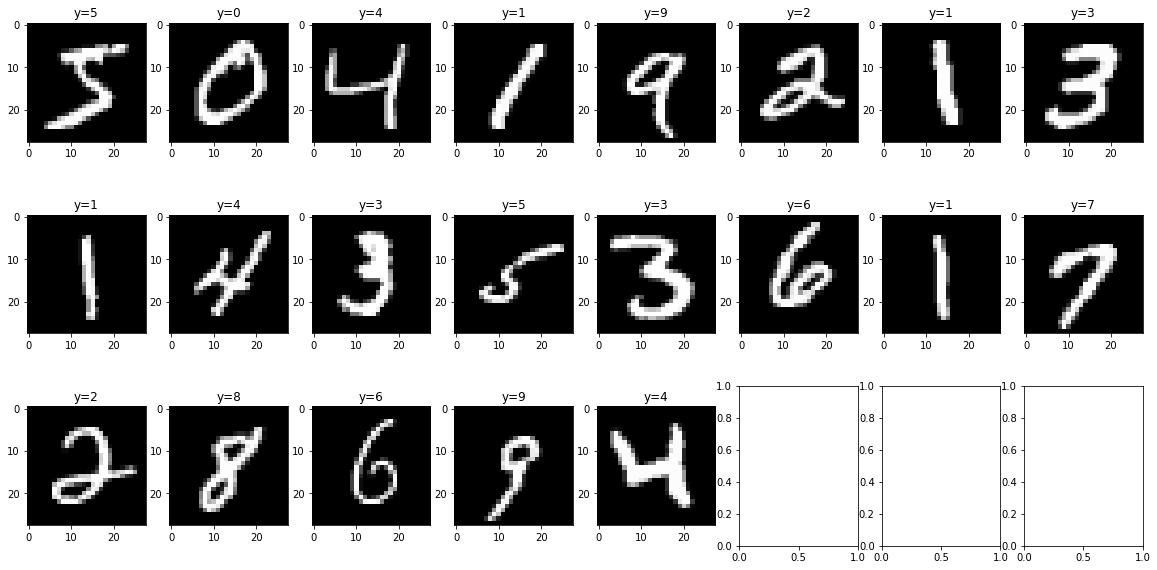

In [ ]:
# plot a grid of samples with targets
def plot_grid(ds, n):
  ncols = 8
  nrows = n // ncols + 1
  plt.subplots(nrows, ncols, figsize=(20, 10))
  for i, (x, y) in enumerate(ds):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(x[0], cmap="gray")
    plt.title(f'y={y:01d}')
    if i >= n: 
      break

plot_grid(train_ds, 20)

In [ ]:
# define a multi-layer perceptrons
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    # first layer 784 --> 100, relu activation
    self.fc1 = nn.Linear(28*28, 100, bias=False)
    self.relu1 = nn.ReLU()
    # second layer 100 --> 50, relu activation
    self.fc2 = nn.Linear(100, 50, bias=False)
    self.relu2 = nn.ReLU()
    # output layer 50 --> 10 class, linear activation
    self.fc3 = nn.Linear(50, 10, bias=False)
  
  def forward(self, x):
    # first layer
    out = self.fc1(x)
    out = self.relu1(out)
    # second layer
    out = self.fc2(out)
    out = self.relu2(out)
    # output layer (10-class)
    out = self.fc3(out)

    return out

# test model with inputs
model = MLP()
# x = torch.zeros(5, 28*28)
# out = model(x)
# print("out.shape", out.shape)

# define cross entropy loss
loss_func = nn.CrossEntropyLoss()

# use Stochastic Gradient Descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# tried with lr=0.001 but not good

In [ ]:
# user DataLoader to create mini-batch

# training dataloader (with shuffling)
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

# test dataloader (no shuffling)
test_dataloader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
# train with GPU
n_epoch = 5
model.cuda()
for epoch in range(n_epoch):

  # training phase
  model.train()
  print(f"epoch {epoch} started")
  for x, y in train_dataloader:

    # compute output of the model on the mini-batch
    x = x.view(len(x), -1).cuda()
    out = model(x)

    # compute loss function
    loss = loss_func(out, y.cuda())

    # calculate derivative and do a gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # testing phase
  model.eval()
  total = len(test_ds)
  total_correct = 0 # count number of correct predictions on test set

  for x, y in test_dataloader:
    with torch.no_grad(): # prevent gradient computation
      x = x.view(len(x), -1).cuda()
      out = model(x)
      # take the maximum output
      pred = torch.argmax(out, dim=1)
      # count the correct predictions
      corrects = (pred == y.cuda()).sum().item()
      total_correct += corrects

  # compute test accuracy for this epoch
  accuracy = total_correct / total
  print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")

epoch 0 started
epoch 0 accuracy 90.17%
epoch 1 started
epoch 1 accuracy 92.64%
epoch 2 started
epoch 2 accuracy 93.79%
epoch 3 started
epoch 3 accuracy 95.05%
epoch 4 started
epoch 4 accuracy 95.36%


In [ ]:
# calculate prediction on test set
ypred = []
targets = []
model.eval()
with torch.no_grad():
  for x, y in test_ds:
    # this is the code to do inference
    x = x.view(len(x), -1).cuda()
    out = model(x)
    pred = torch.argmax(out, dim=1).item()

    # append the prediction results
    ypred.append(pred)
    targets.append(y)

n_incorrect 354


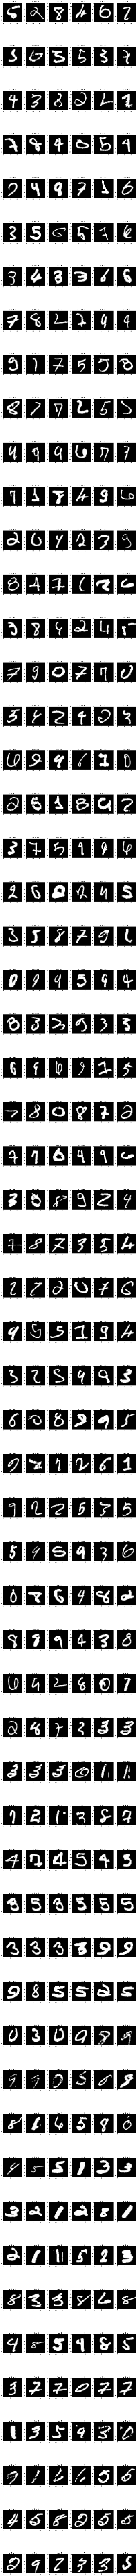

In [ ]:
# plot first n incorrect predictions
def plot_grid_label(ds, n, ypred):
  # n = len(ds)
  ncols = 6
  nrows = n // ncols + (1 if n % ncols > 0 else 0)
  plt.subplots(nrows, ncols, figsize=(20,400))
  k = 0
  for i, (x, y) in enumerate(ds):
    if y != ypred[i]:
      plt.subplot(nrows, ncols, k+1)
      plt.imshow(x[0], cmap="gray")
      plt.title(f'y={y:01d} yp={ypred[i]:01d}')

      k += 1
      if k >= n: 
        break

n_incorrect = sum([x != y for x, y in zip(targets, ypred)])
plot_grid_label(test_ds, n_incorrect, ypred)
print("n_incorrect", n_incorrect)

# Exercises: Try improving performance of the model by
1. Using more training epochs
2. Using different learning rate
2. Using different network configurations
3. Using different layer: Dropout, BatchNormalization
4. Using different architecture: Residual Network 
5. Refactor your code so that you could reuse
  *   data loading code
  *   model code
  *   training code
  *   evaluation code
  *   inference code
6. Learn to use PyTorch Lightning library, a wrapper for PyTorch

In [ ]:
# try with BatchNormalization
class BN(nn.Module):
    def __init__(self): 
        super(BN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
model_bn = BN()
print(model_bn)

loss_func = nn.CrossEntropyLoss()
opt_bn = torch.optim.SGD(model_bn.parameters(), lr=0.01)

BN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
def train(model_bn, n_epoch=10):
  print(f'training with: ', model_bn)
  for epoch in range(n_epoch):
    model_bn.train()
    print(f"epoch {epoch} started")
    for x, y in train_dataloader:
      opt_bn.zero_grad()
      out_bn = model_bn(x)
      loss_bn = loss_func(out_bn, y)
      loss_bn.backward()
      opt_bn.step()
    
    model_bn.eval()
    total = len(test_ds)
    total_correct = 0 # count number of correct predictions on test set

    for x, y in test_dataloader:
      with torch.no_grad(): # prevent gradient computation
        x = x.view(len(x), -1)
        out = model_bn(x)
        # take the maximum output
        pred = torch.argmax(out, dim=1)
        # count the correct predictions
        corrects = (pred == y).sum().item()
        total_correct += corrects
    # compute test accuracy for this epoch
    accuracy = total_correct / total
    print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")

train(model_bn)

training with:  BN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)
epoch 0 started
epoch 0 accuracy 96.46%
epoch 1 started
epoch 1 accuracy 96.85%
epoch 2 started
epoch 2 accuracy 96.95%
epoch 3 started
epoch 3 accuracy 97.19%
epoch 4 started
epoch 4 accuracy 97.21%
epoch 5 started
epoch 5 accuracy 97.29%
epoch 6 started
epoch 6 accuracy 97.46%
epoch 7 started
epoch 7 accuracy 97.58%
epoch 8 started
epoch 8 accuracy 97.45%
epoch 9 started
epoch 9 accuracy 97.58%


In [ ]:
N = 100
# model dropout
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N, N),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N, 1),
)
# optimizer
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
# loss function
loss_dr = torch.nn.MSELoss()

In [ ]:
# try with BatchNormalization and Dropout but output is not good, approximately 10% :(
class BN_DR(nn.Module):
    def __init__(self): 
        super(BN_DR, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 48),
            nn.BatchNorm1d(48),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
model_bn_dr = BN_DR()
train(model_bn_dr)

training with:  BN_DR(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=24, bias=True)
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=24, out_features=10, bias=True)
  )
)
epoch 0 started
epoch 0 accuracy 11.15%
epoch 1 started
epoch 1 accuracy 11.48%
epoch 2 started
epoch 2 accuracy 11.26%
epoch 3 started
epoch 3 accuracy 11.39%
epoch 4 started
epoch 4 accuracy 11.27%
epoch 5 started
epoch 5 accuracy 10.93%
epoch 6 started
epoch 6 accuracy 11.20%
epoch 7 started
epoch 7 accuracy 11.28%
epoch 8 started
epoch 8 accuracy 10.79%
epoch 9 started
epoch 9 accuracy 11.19%
